In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, precision_score
from category_encoders import BinaryEncoder
from imblearn.over_sampling import SMOTE
from joblib import dump, load
import graphviz

In [3]:
# Read the Netflix dataset
netflix_data = pd.read_csv('../data/netflix_titles.csv')

# Cell 3: Display basic info
netflix_data.info()
netflix_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
# drop rows with missing critical values like type, title, release_year, duration, listed_in
cleaned_data = netflix_data.dropna(subset=["type", "title", "release_year", "duration", "listed_in", "country"])

In [5]:
#Remove duplicate rows based on specified columns
cleaned_data = cleaned_data.drop_duplicates(subset=["title"])

In [6]:
print(cleaned_data['type'].unique())

['Movie' 'TV Show']


C:\Users\Zino\AppData\Local\Temp\ipykernel_7224\684363676.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cleaned_data, x="type", palette="Set2")
C:\Users\Zino\AppData\Local\Temp\ipykernel_7224\684363676.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_countries.index, x=top_countries.values, palette="Set3")


Text(0, 0.5, 'Country')

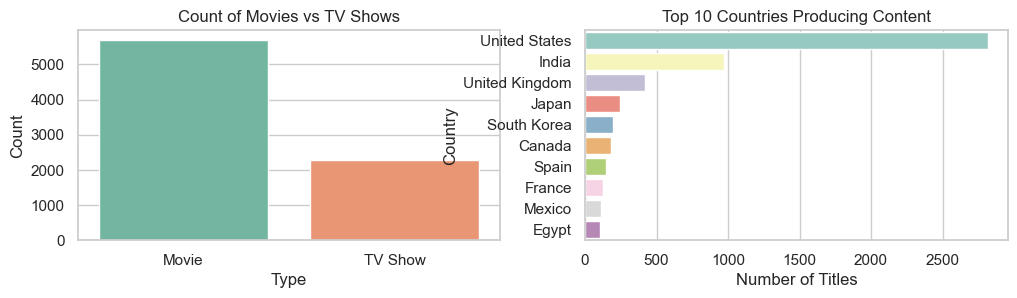

In [7]:
# Cell 6: Visual Exploration
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# 1. Count of Movies vs TV Shows
plt.subplot(2, 2, 1)
sns.countplot(data=cleaned_data, x="type", palette="Set2")
plt.title("Count of Movies vs TV Shows")
plt.xlabel("Type")
plt.ylabel("Count")

# 2. Top 10 Countries Producing Content
top_countries = cleaned_data['country'].value_counts().head(10)
plt.subplot(2, 2, 2)
sns.barplot(y=top_countries.index, x=top_countries.values, palette="Set3")
plt.title("Top 10 Countries Producing Content")
plt.xlabel("Number of Titles")
plt.ylabel("Country")


C:\Users\Zino\AppData\Local\Temp\ipykernel_7224\2305683619.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(genres), palette="viridis")


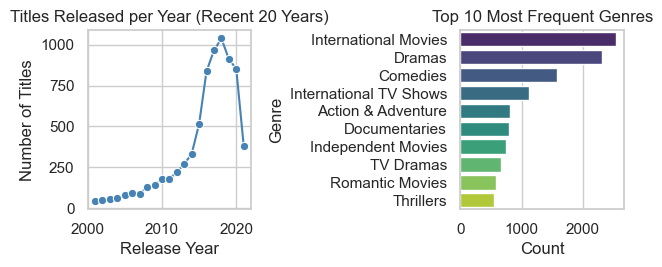

In [8]:
# 3. Count of Titles per Release Year (last 20 years)
recent_years = cleaned_data[cleaned_data['release_year'] >= cleaned_data['release_year'].max() - 20]
year_counts = recent_years['release_year'].value_counts().sort_index()
plt.subplot(2, 2, 3)
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o', color="steelblue")
plt.title("Titles Released per Year (Recent 20 Years)")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")

# 4. Most Frequent Genres (Top 10)
from collections import Counter
# Flatten genre list
genre_list = cleaned_data['listed_in'].str.split(', ').sum()
top_genres = Counter(genre_list).most_common(10)
genres, counts = zip(*top_genres)
plt.subplot(2, 2, 4)
sns.barplot(x=list(counts), y=list(genres), palette="viridis")
plt.title("Top 10 Most Frequent Genres")
plt.xlabel("Count")
plt.ylabel("Genre")

plt.tight_layout()
plt.show()


In [9]:
#Feature Engineering & Model Preparation

In [10]:
# Clone the cleaned dataset to avoid modifying original
feature_data = cleaned_data.copy()

In [11]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
type_encoder = LabelEncoder()

# Apply encoding to the 'type' column
feature_data['type_encoded'] = type_encoder.fit_transform(feature_data['type'])
# Check the encoded values

print(feature_data['type_encoded'].head())
print(feature_data['type_encoded'].unique())

0    0
1    1
4    1
7    0
8    1
Name: type_encoded, dtype: int32
[0 1]


In [12]:
feature_data['type'] = feature_data['type'].map({'Movie': 0, 'TV Show': 1})

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
import numpy as np

# 2. Extract numerical duration
# Convert 'duration' column to numeric: extract minutes or seasons
def parse_duration(x):
    try:
        return int(x.split(' ')[0])
    except:
        return np.nan

feature_data['parsed_duration'] = feature_data['duration'].apply(parse_duration)

In [14]:
# 3. Encode genres using MultiLabelBinarizer
# 'listed_in' contains comma-separated genres -> we turn them into binary features
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(feature_data['listed_in'].str.split(', '))
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

In [15]:
# 4. Encode country using Label Encoding (for simplicity — OneHot can be too sparse)
from sklearn.preprocessing import LabelEncoder
country_encoder = LabelEncoder()
feature_data['country_encoded'] = country_encoder.fit_transform(feature_data['country'])

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def recommend_content(genre_input, type_input, release_year_input, country_input):
    """
    Recommend Netflix content matching:
    - At least 2 selected genres
    - Content type (Movie/TV Show)
    - Country (case-insensitive partial match)
    - Release year >= selected year
    """
    # Normalize genre input
    genre_input = [g.strip().title() for g in genre_input]

    # Step 1: Filter data by type, country, and release year range
    filtered_data = cleaned_data[
        (cleaned_data['type'] == ('Movie' if type_input == 0 else 'TV Show')) &
        (cleaned_data['country'].str.contains(country_input, case=False, na=False)) &
        (cleaned_data['release_year'] >= release_year_input)
    ]

    # Step 2: Match at least 2 selected genres
    def genres_match_at_least_two(genres_str):
        content_genres = [g.strip() for g in genres_str.split(',')]
        return sum(1 for g in genre_input if g in content_genres) >= 2

    filtered_data = filtered_data[filtered_data['listed_in'].apply(genres_match_at_least_two)]

    if filtered_data.empty:
        print("No content found matching your criteria.")
        return pd.DataFrame()

    # Step 3: Prepare features for NearestNeighbors
    filtered_indices = filtered_data.index.intersection(genres_df.index)
    filtered_genres_df = genres_df.loc[filtered_indices]
    filtered_features = pd.concat([
        filtered_data[['type', 'release_year', 'parsed_duration', 'country_encoded']],
        filtered_genres_df
    ], axis=1).fillna(0)

    # Step 4: Fit Nearest Neighbors model on filtered data
    filtered_scaled = scaler.transform(filtered_features)
    local_model = NearestNeighbors(n_neighbors=min(10, len(filtered_data)), algorithm='auto')
    local_model.fit(filtered_scaled)

    # Step 5: Create scaled user input vector
    avg_duration = feature_data[feature_data['type'] == type_input]['parsed_duration'].mean()
    user_input = pd.DataFrame([{
        'type': type_input,
        'release_year': release_year_input,
        'parsed_duration': avg_duration,
        'country_encoded': country_encoder.transform([country_input])[0]
    }])

    for genre in mlb.classes_:
        user_input[genre] = 1 if genre in genre_input else 0

    user_input_scaled = scaler.transform(user_input)

    # Step 6: Get nearest neighbors
    distances, indices = local_model.kneighbors(user_input_scaled)
    recommendations = filtered_data.iloc[indices[0]]

    return recommendations[['title', 'listed_in', 'type', 'duration', 'country', 'rating', 'description']]


In [17]:
# 5. Final feature set
from sklearn.neighbors import NearestNeighbors

final_features = pd.concat([
    feature_data[['type', 'release_year', 'parsed_duration', 'country_encoded']],
    genres_df
], axis=1)

# Handle missing values (e.g., NaN in parsed_duration)
final_features = final_features.fillna(0)

# Normalize features for Nearest Neighbors
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(final_features)

# --- Train Nearest Neighbors Model ---
model = NearestNeighbors(n_neighbors=10, algorithm='auto')
model.fit(X_scaled)

print("Feature engineering complete and Nearest Neighbors model is trained.")

Feature engineering complete and Nearest Neighbors model is trained.


In [18]:
#User Input System & Recommendation Generation

In [19]:
def recommend_content(genre_input, type_input, release_year_input, country_input):
    # Normalize genre input
    genre_input = [g.strip().title() for g in genre_input]

    # Use average duration for the selected type
    avg_duration = feature_data[feature_data['type'] == type_input]['parsed_duration'].mean()

    # Step 1: Create user input features
    user_input = pd.DataFrame([{
        'type': type_input,
        'release_year': release_year_input,
        'parsed_duration': avg_duration,
        'country_encoded': country_encoder.transform([country_input])[0]
    }])

    # Step 2: Add genre columns
    for genre in mlb.classes_:
        user_input[genre] = 0
    for genre in genre_input:
        if genre in mlb.classes_:
            user_input[genre] = 1

    # Step 3: Scale the input
    user_input_scaled = scaler.transform(user_input)

    # Step 4: Find nearest neighbors
    distances, indices = model.kneighbors(user_input_scaled)

    # Step 5: Get recommendations
    recommendations = cleaned_data.iloc[indices[0]]
    return recommendations[['title', 'listed_in', 'type', 'duration', 'country', 'rating', 'description']]

In [20]:
# Example: Get user preferences
# For testing, you can provide the following sample inputs (you can later collect inputs interactively):
genre_input = ['Action', 'Drama']  # User prefers these genres
type_input = 0  # User selected "Movie"
release_year_input = 2021  # User prefers movies released in 2021
country_input = 'United States'  # User prefers US-based content

# Call the updated recommend_content function (no duration_input)
recommendations = recommend_content(genre_input, type_input, release_year_input, country_input)

# Display the recommended titles
print(recommendations)


                                   title  \
8200                       The Bachelors   
8202                        The Bad Kids   
8678                     Vincent N Roxxy   
8176                     The 24 Hour War   
8036          Sleeping with Other People   
8367                      The Invitation   
8441  The Nutcracker and the Four Realms   
8750                       Winter's Bone   
8642                                Tusk   
8258                          The Croods   

                                         listed_in   type duration  \
8200                                        Dramas  Movie  100 min   
8202                                 Documentaries  Movie  101 min   
8678                             Dramas, Thrillers  Movie  101 min   
8176                  Documentaries, Sports Movies  Movie  100 min   
8036          Comedies, Dramas, Independent Movies  Movie  101 min   
8367  Horror Movies, Independent Movies, Thrillers  Movie  100 min   
8441                     

In [21]:
#DECISION TREE: Model Training & Evaluation for Rating predicion

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, classification_report, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Enhanced Rating Cleaning and Preparation
def prepare_ratings(y):
    """Clean and standardize ratings with comprehensive mapping"""
    rating_map = {
        'G': 'G',
        'PG': 'PG',
        'PG-13': 'PG-13',
        'R': 'R',
        'NC-17': 'NC-17',
        'TV-Y': 'TV-Y',
        'TV-Y7': 'TV-Y7',
        'TV-Y7-FV': 'TV-Y7-FV',
        'TV-G': 'TV-G',
        'TV-PG': 'TV-PG',
        'TV-14': 'TV-14',
        'TV-MA': 'TV-MA'
    }
    
    # Filter out durations and unknown ratings
    y = y[~y.astype(str).str.contains('min')]  # Remove duration entries
    y = y.map(rating_map).dropna()  # Apply mapping and drop NA/unmapped
    
    return y

# Prepare target
y = prepare_ratings(feature_data['rating'])
X = final_features.loc[y.index]  # Align features

In [23]:
# 2. Improved Train-Test Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
# 3. Enhanced Model Selection and Training
# Using RandomForest for better performance
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

# Cross-validation
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Cross-validated Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Train model
clf.fit(X_train, y_train)

c:\Users\Zino\miniconda3\envs\ortega\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-validated Accuracy: 0.26 ± 0.02


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=200, random_state=42)


=== Detailed Classification Report ===
              precision    recall  f1-score   support

           G       0.19      0.50      0.28         8
       NC-17       0.00      0.00      0.00         1
          PG       0.13      0.21      0.16        56
       PG-13       0.26      0.42      0.32        97
           R       0.26      0.27      0.26       158
       TV-14       0.38      0.43      0.41       386
        TV-G       0.04      0.08      0.05        38
       TV-MA       0.51      0.17      0.26       586
       TV-PG       0.10      0.03      0.05       155
        TV-Y       0.06      0.31      0.11        45
       TV-Y7       0.13      0.43      0.20        47
    TV-Y7-FV       0.00      0.00      0.00         1

    accuracy                           0.26      1578
   macro avg       0.17      0.24      0.17      1578
weighted avg       0.35      0.26      0.26      1578


Accuracy: 25.98
Weighted Precision: 34.58


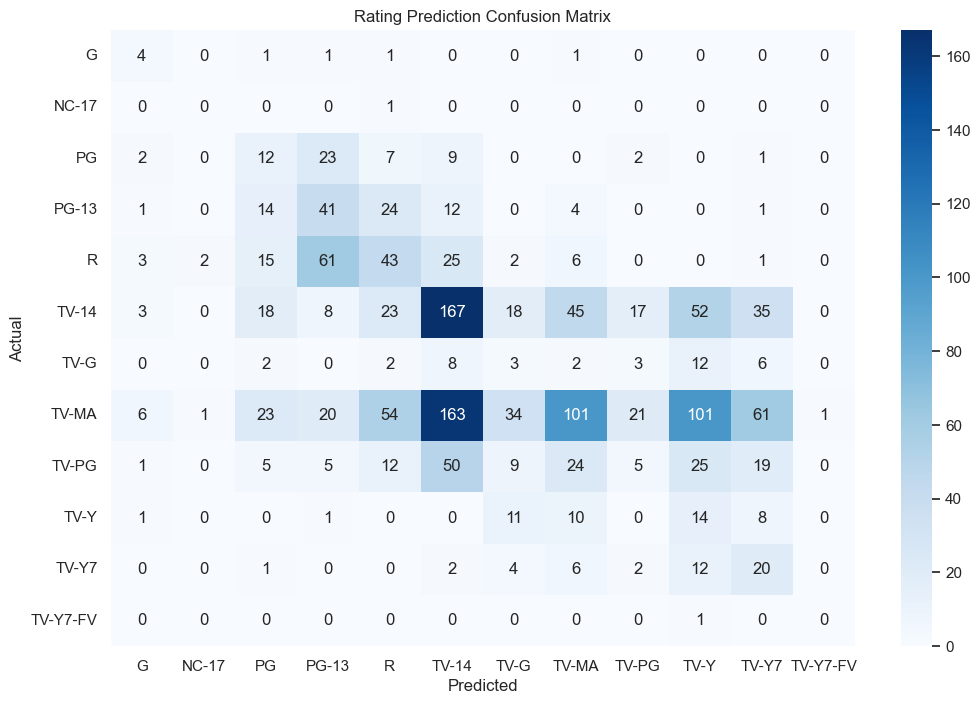

In [25]:
# 4. Comprehensive Evaluation
y_pred = clf.predict(X_test)

print("\n=== Detailed Classification Report ===")
print(classification_report(y_test, y_pred, zero_division=0))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred) * 100:.2f}")
print(f"Weighted Precision: {precision_score(y_test, y_pred, average='weighted') * 100:.2f}")

# Confusion Matrix Visualization
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Rating Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

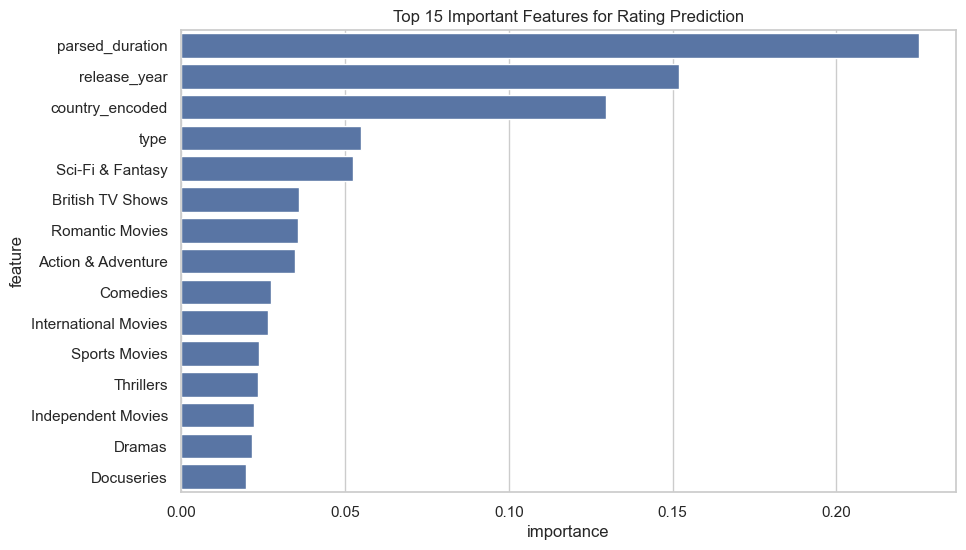

In [26]:
# 5. Feature Importance Analysis
feature_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_imp.head(15))
plt.title('Top 15 Important Features for Rating Prediction')
plt.show()

In [27]:
# 6. Production-Ready Prediction Function
def predict_rating(features):
    """Predict rating with confidence scores"""
    pred = clf.predict(features)
    proba = clf.predict_proba(features)
    
    results = []
    for i, rating in enumerate(pred):
        confidence = proba[i][clf.classes_ == rating][0]
        results.append({
            'predicted_rating': rating,
            'confidence': round(confidence, 2),
            'alternative_ratings': dict(zip(
                clf.classes_,
                [round(p, 2) for p in proba[i]]
            ))
        })
    
    return results

In [28]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# 1. Train a visualization-friendly Decision Tree
tree_model = DecisionTreeClassifier(
    max_depth=4,               # Limited for interpretability
    min_samples_split=20,      # Prevent overfitting
    class_weight='balanced',   # Handle imbalanced classes
    random_state=42
)
tree_model.fit(X_train, y_train)

# 2. Export the decision tree to DOT file
export_graphviz(
    tree_model,
    out_file='../outputs/rating_tree.dot',  # Output file path
    feature_names=X.columns,                # Feature names
    class_names=tree_model.classes_,        # Rating categories
    filled=True,                            # Color coding
    rounded=True,                           # Rounded boxes
    special_characters=True                 # Special symbols
)

print("Decision tree exported to rating_tree.dot")

Decision tree exported to rating_tree.dot


In [29]:
import joblib

# Save the model with joblib
joblib.dump(clf, '../data/rating_predictor.joblib')

# Verify the classes are what we expect
print("Model saved with these rating classes:")
print(clf.classes_)

Model saved with these rating classes:
['G' 'NC-17' 'PG' 'PG-13' 'R' 'TV-14' 'TV-G' 'TV-MA' 'TV-PG' 'TV-Y'
 'TV-Y7' 'TV-Y7-FV']
